In [1]:
import matplotlib.pyplot as plt
import numpy as np
import math
import pandas as pd
import random

from scipy import eye, asarray, dot, sum, diag
from scipy.linalg import svd
from mpl_toolkits.basemap import Basemap
import matplotlib as mpl
from matplotlib import cm
from colorspacious import cspace_converter
from collections import OrderedDict
from netCDF4 import Dataset
from numpy import linspace
from numpy import meshgrid


import PCA_functions as pf
import Extreme_functions as ef

from tigramite import plotting as tp
from tigramite.pcmci import PCMCI
from tigramite.independence_tests import ParCorr, CMIknn
import tigramite.data_processing as pp

from Data import Data
from datetime import datetime

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

import itertools
from collections import Counter
import pickle

from numpy import linalg as LA

import matplotlib.cm as cm

from scipy.special import inv_boxcox
from scipy import stats

from matplotlib import animation

import scipy.stats as st

import reverse_geocoder as rg

from pandas_datareader import wb
import scipy.stats as st

import Rung as rung

from pandas_datareader import wb

import seaborn as sns


import seaborn as sns
import feature_finder_keiko as ff
import feature_finder_f as ff1

from scipy import signal

plt.rcParams["figure.figsize"] = (20,10)

Could not import rpy package
Could not import r-package RCIT


/home/mathsys2/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [3]:
def PCA_soil_rotated(file_name, code, temporal_limits,n_components_sst=40, missing_value=0):
    sst = Data(file_name,code,temporal_limits, missing_value= missing_value)

    result = sst.get_data()
    lon_sst_list = sst.get_lon_list()
    lat_sst_list = sst.get_lat_list()
    lon = sst.get_lon()
    lat = sst.get_lat()
    
    lons = np.arange(lon[0],lon[-1],2)
    lats = np.arange(lat[0],lat[-1],-2)

    INDEX = []
    for i in range(len(lon_sst_list)):
        if (lon_sst_list[i] in lons) and (lat_sst_list[i] in lats):
            INDEX.append(i)
    
    result = result[:,INDEX]
    lat_sst_list = np.array(lat_sst_list)[INDEX]
    lon_sst_list = np.array(lon_sst_list)[INDEX]

    result_sst, avgs, stds = pf.deseasonalize_avg_std(np.array(result))
    result_sst = signal.detrend(result_sst, axis=0)
    weights = np.sqrt(np.abs(np.cos(np.array(lat_sst_list)* math.pi/180)))
    for i in range(len(weights)):
        result_sst[:,i] = weights[i] * result_sst[:,i]

    data_sst = pd.DataFrame(result_sst)
        
    V, U, S, ts, eig, explained, max_comps = rung.pca_svd(data_sst,truncate_by='max_comps', max_comps=n_components_sst)
        
    Vr, Rot = rung.varimax(V)
    Vr = rung.svd_flip(Vr)

    # Get explained variance of rotated components
    s2 = np.diag(S)**2 / (ts.shape[0] - 1.)

    # matrix with diagonal containing variances of rotated components
    S2r = np.dot(np.dot(np.transpose(Rot), np.matrix(np.diag(s2))), Rot)
    expvar = np.diag(S2r)

    sorted_expvar = np.sort(expvar)[::-1]
    # s_orig = ((Vt.shape[1] - 1) * s2) ** 0.5

    # reorder all elements according to explained variance (descending)
    nord = np.argsort(expvar)[::-1]
    Vr = Vr[:, nord]

    # Get time series of UNMASKED data
    comps_ts = np.matmul(np.array(data_sst),Vr)

    df_sst = pd.DataFrame({"lons":lon_sst_list,"lats":lat_sst_list})

    lon_temp = df_sst["lons"].values
    lon_temp[lon_temp > 180] = lon_temp[lon_temp > 180] -360
    df_sst["lons"].vlues = lon_temp
    
    return(result_sst, comps_ts, Vr, df_sst, avgs, stds)

In [5]:
train_start = 1976
validation_end = 2010
n_components_soil = 40
f = 12
tau = 3
cc = "ET"

temporal_limits = {"time_min":datetime(train_start, 1, 1, 0, 0),"time_max":datetime(validation_end, 12, 1, 0, 0)}

In [6]:
data_sst, ts, Vr, df_sst, avg, std = PCA_soil_rotated('../../../nc/soilw.mon.mean.v2.nc',"soilw",temporal_limits)

/home/mathsys2/Files/Time_Series/Climate_Network/Causality/TimeSeries/notebooks/whole_data_validation/Data.py:36: RuntimeWarning: invalid value encountered in less
  self._mask = (var[:,:,-1]!= missing_value)
/home/mathsys2/Files/Time_Series/Climate_Network/Causality/TimeSeries/notebooks/whole_data_validation/Data.py:36: RuntimeWarning: invalid value encountered in greater
  self._mask = (var[:,:,-1]!= missing_value)
/home/mathsys2/anaconda3/lib/python3.6/site-packages/numpy/core/_asarray.py:85: RuntimeWarning: invalid value encountered in less
  return array(a, dtype, copy=False, order=order)
/home/mathsys2/anaconda3/lib/python3.6/site-packages/numpy/core/_asarray.py:85: RuntimeWarning: invalid value encountered in greater
  return array(a, dtype, copy=False, order=order)


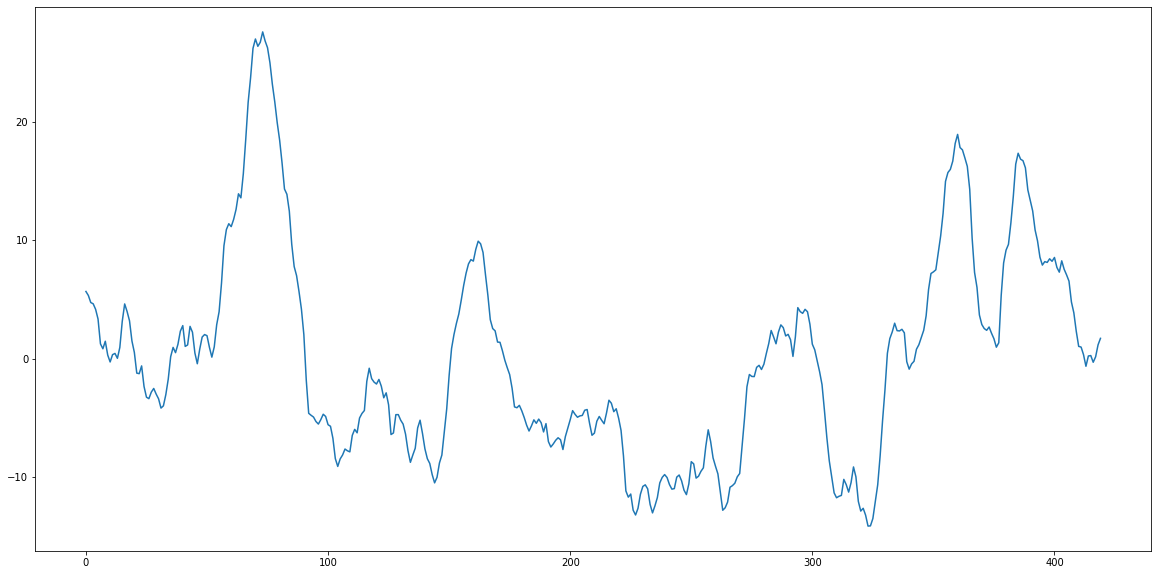

In [12]:
plt.plot(ts[:,2])

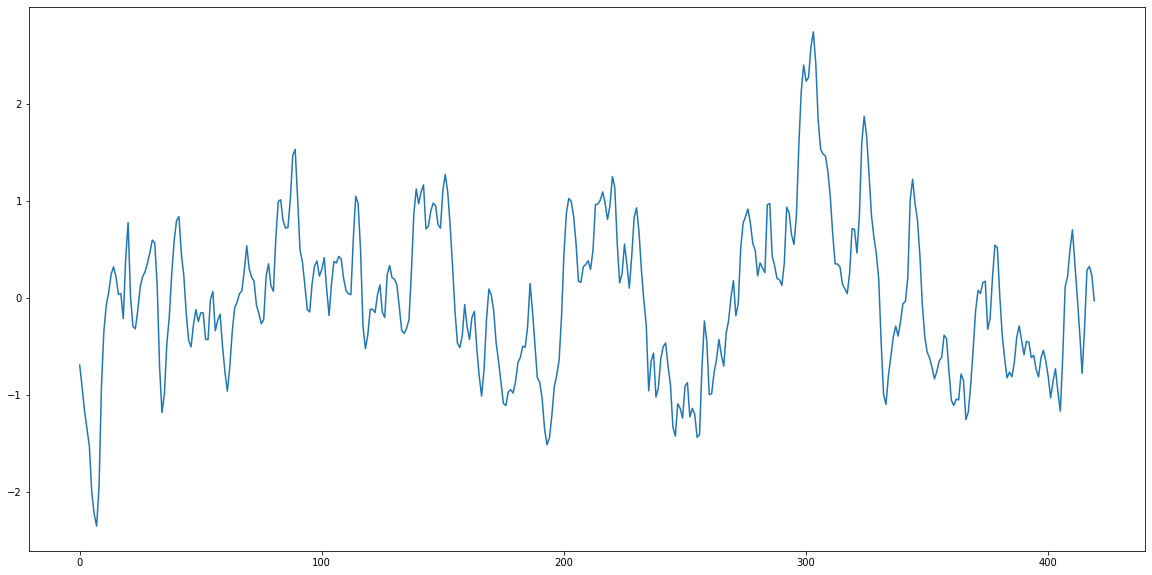

In [15]:
plt.plot(data_sst[:,1])

In [16]:
sst = Data('../../../nc/soilw.mon.mean.v2.nc',"soilw",temporal_limits, missing_value= 0)

result = sst.get_data()
lon_list = sst.get_lon_list()
lat_list = sst.get_lat_list()
lon = sst.get_lon()
lat = sst.get_lat()


lons = np.arange(lon[0],lon[-1],2)
lats = np.arange(lat[0],lat[-1],-2)

index = []
for i in range(len(lon_list)):
    if (lon_list[i] in lons) and (lat_list[i] in lats):
        index.append(i)

result = result[:,index]
lat_list = np.array(lat_list)[index]
lon_list = np.array(lon_list)[index]



/home/mathsys2/Files/Time_Series/Climate_Network/Causality/TimeSeries/notebooks/whole_data_validation/Data.py:36: RuntimeWarning: invalid value encountered in less
  self._mask = (var[:,:,-1]!= missing_value)
/home/mathsys2/Files/Time_Series/Climate_Network/Causality/TimeSeries/notebooks/whole_data_validation/Data.py:36: RuntimeWarning: invalid value encountered in greater
  self._mask = (var[:,:,-1]!= missing_value)
/home/mathsys2/anaconda3/lib/python3.6/site-packages/numpy/core/_asarray.py:85: RuntimeWarning: invalid value encountered in less
  return array(a, dtype, copy=False, order=order)
/home/mathsys2/anaconda3/lib/python3.6/site-packages/numpy/core/_asarray.py:85: RuntimeWarning: invalid value encountered in greater
  return array(a, dtype, copy=False, order=order)


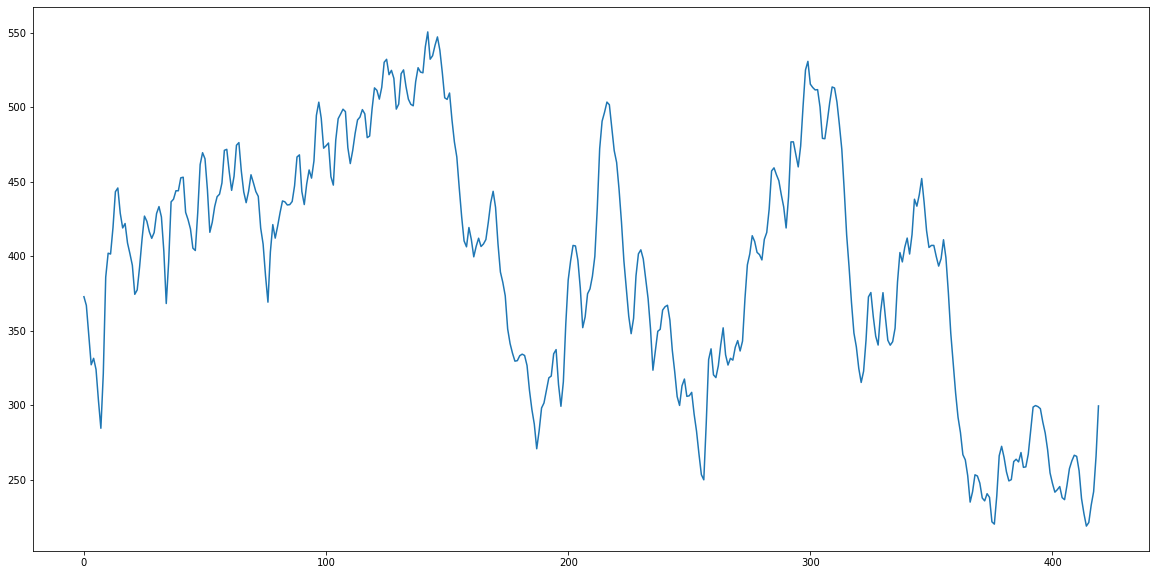

In [18]:
plt.plot(result[:,0])

In [36]:
x = result[:,0]

In [23]:
w = np.fft.fft(x)
freqs = np.fft.fftfreq(len(x))

for coef,freq in zip(w,freqs):
    if coef:
        print('{} * exp(2 pi i t * {})'.format(coef,freq))

[372.84777832+0.j] * exp(2 pi i t * 0.0)
[367.02182007+0.j] * exp(2 pi i t * 0.002380952380952381)
[346.91390991+0.j] * exp(2 pi i t * 0.004761904761904762)
[327.14736938+0.j] * exp(2 pi i t * 0.0071428571428571435)
[331.47805786+0.j] * exp(2 pi i t * 0.009523809523809525)
[323.98013306+0.j] * exp(2 pi i t * 0.011904761904761906)
[303.10308838+0.j] * exp(2 pi i t * 0.014285714285714287)
[284.5177002+0.j] * exp(2 pi i t * 0.01666666666666667)
[321.150177+0.j] * exp(2 pi i t * 0.01904761904761905)
[385.9831543+0.j] * exp(2 pi i t * 0.02142857142857143)
[402.05670166+0.j] * exp(2 pi i t * 0.02380952380952381)
[401.50878906+0.j] * exp(2 pi i t * 0.026190476190476195)
[419.18017578+0.j] * exp(2 pi i t * 0.028571428571428574)
[443.32513428+0.j] * exp(2 pi i t * 0.030952380952380953)
[445.84262085+0.j] * exp(2 pi i t * 0.03333333333333334)
[428.89041138+0.j] * exp(2 pi i t * 0.03571428571428572)
[419.01519775+0.j] * exp(2 pi i t * 0.0380952380952381)
[421.9927063+0.j] * exp(2 pi i t * 0.04047

In [46]:
from scipy import fftpack, signal
f_s = 1000
X = fftpack.fft(x)
freqs = fftpack.fftfreq(len(x))* f_s

/home/mathsys2/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  This is separate from the ipykernel package so we can avoid doing imports until


Text(0, 0.5, 'Frequency Domain (Spectrum) Magnitude')

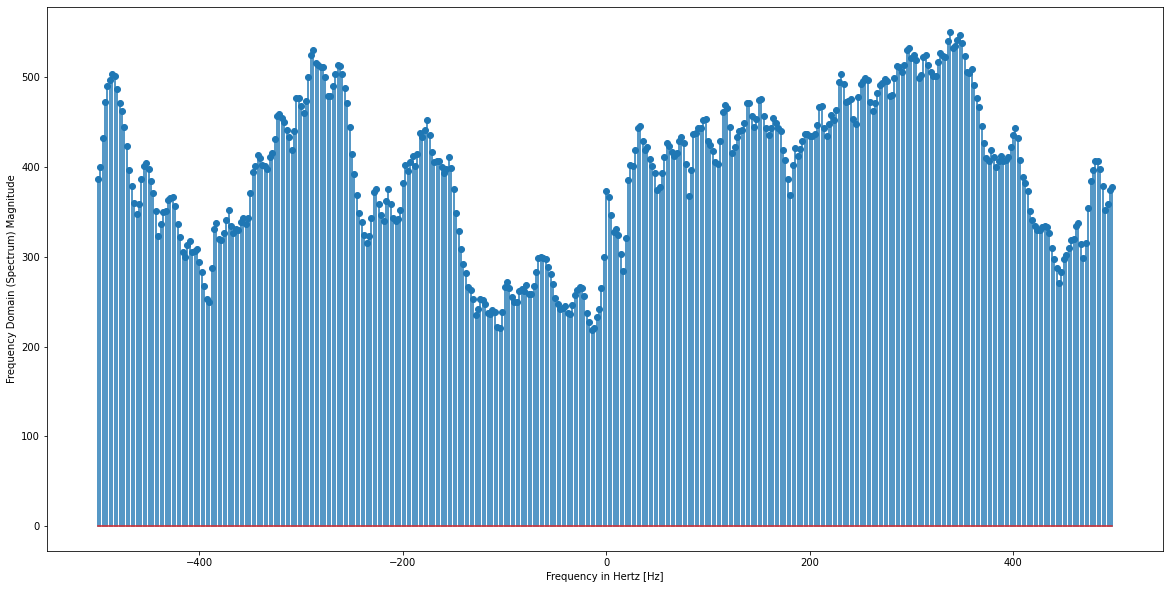

In [47]:
fig, ax = plt.subplots()

ax.stem(freqs, np.abs(X))
ax.set_xlabel('Frequency in Hertz [Hz]')
ax.set_ylabel('Frequency Domain (Spectrum) Magnitude')